# Connect to drive folder

For this notebook, we import the dataset, named `public_data.npz`, from a folder on our drive, named `dip_learners_folder`.



In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/dip_learners_folder

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/dip_learners_folder


# Import libraries

In [ ]:
seed = 2

# Reduce randomness as much as possible
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import random
random.seed(seed)

import numpy as np
np.random.seed(seed)

import tensorflow as tf
tf.random.set_seed(seed)


# Import other libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

from sklearn.model_selection import train_test_split
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.utils import class_weight

from sklearn.model_selection import KFold

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Prepare the data

### Load the dataset

In [ ]:
dataset = np.load('public_data.npz', allow_pickle=True)

# dataset contains 2 arrays: data and labels
X = dataset['data']
y = dataset['labels']


In [ ]:
# Count the occurrences of 'healthy' and 'unhealthy'
healthy_count = np.count_nonzero(y == 'healthy')
unhealthy_count = np.count_nonzero(y == 'unhealthy')

print("Count of 'healthy' labels:", healthy_count)
print("Count of 'unhealthy' labels:", unhealthy_count)
print("Percentage of healthy ", healthy_count/5200 )

Count of 'healthy' labels: 3199
Count of 'unhealthy' labels: 2001
Percentage of healthy  0.6151923076923077


### Remove outliers

There aren't what are usually called outliers, but there are really unrelated images, i.e. troll images depicting Shrek.

In [ ]:
## DELETING TROLL IMAGES

# cleaning images from trolls and shreks
shrek = X[58]
troll = X[2150]
shrek_indexes = []
troll_indexes = []
for i in range(0, len(X)):
    shrekDiff = np.mean(np.abs(shrek - X[i]))
    trollDiff = np.mean(np.abs(troll - X[i]))
    if(shrekDiff == 0.0):
        shrek_indexes.append(i)
    elif(trollDiff == 0.0):
        troll_indexes.append(i)

rm_indexes = np.concatenate((shrek_indexes, troll_indexes))

X_clean = np.delete(X, rm_indexes, axis = 0)
y_clean = np.delete(y, rm_indexes, axis = 0)

print('Length of the dataset (images):', len(X_clean))
print('Length of the labels: ', len(y_clean))

## Final result: images + labels

Length of the dataset (images): 5004
Length of the labels:  5004


### Set for training, validation and test

In [ ]:
### Change labels to {0,1}
# healthy = 0, unhealthy = 1

y_clean = (np.array(y_clean) == 'unhealthy').astype(int)

In [ ]:
# Split train_val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_clean, y_clean, random_state=seed, test_size=.20)

In [ ]:
# Count the occurrences of 'healthy' and 'unhealthy' in X_train
#healthy_count = np.count_nonzero(y_train == 0)
#unhealthy_count = np.count_nonzero(y_train == 1)

print("Count of 'healthy' labels:", healthy_count)
print("Count of 'unhealthy' labels:", unhealthy_count)

Count of 'healthy' labels: 3199
Count of 'unhealthy' labels: 2001


# Train model: basic model

### Model structure

In [ ]:
xavier_init = tf.keras.initializers.GlorotNormal(seed=seed)

base_model = tf.keras.applications.ConvNeXtBase(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
base_model.trainable = False

model = tfk.Sequential([
        base_model,
        tfkl.Flatten(),
        tfkl.Dense(2048, activation='relu', kernel_initializer=xavier_init),
        tfkl.Dense(1024, activation='relu', kernel_initializer=xavier_init),
        tfkl.Dense(256, activation='relu', kernel_initializer=xavier_init),
        tfkl.Dense(64, activation='relu', kernel_initializer=xavier_init),
        tfkl.Dense(1, activation='sigmoid', kernel_initializer=xavier_init)
    ])

model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer='Adam', metrics=['accuracy', 'Precision','Recall'])
model.summary()

350926856/350926856 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convnext_base (Functional)  (None, 3, 3, 1024)        87566464  
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 2048)              18876416  
                                                                 
 dense_1 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_2 (Dense)             (None, 256)               262400    
                                                                 
 dense_3 (Dense)             (None, 64)                16448     
                                                       

### Train the model

In [ ]:
### Fit the model
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=10,
    restore_best_weights=True)

history = model.fit(
    X_train,
    y_train,
    batch_size=32, #default parameter
    epochs=200,
    validation_data=(X_val, y_val),
    callbacks = [early_stopping]
)

Epoch 1/200
126/126 [==============================] - 66s 272ms/step - loss: 0.6260 - accuracy: 0.7667 - precision: 0.7126 - recall: 0.6359 - val_loss: 0.4794 - val_accuracy: 0.7802 - val_precision: 0.6987 - val_recall: 0.7864
Epoch 2/200
126/126 [==============================] - 24s 195ms/step - loss: 0.3050 - accuracy: 0.8766 - precision: 0.8567 - recall: 0.8066 - val_loss: 0.4018 - val_accuracy: 0.8352 - val_precision: 0.7949 - val_recall: 0.7889
Epoch 3/200
126/126 [==============================] - 26s 208ms/step - loss: 0.2054 - accuracy: 0.9186 - precision: 0.9102 - recall: 0.8691 - val_loss: 0.3826 - val_accuracy: 0.8581 - val_precision: 0.8092 - val_recall: 0.8417
Epoch 4/200
126/126 [==============================] - 21s 170ms/step - loss: 0.1733 - accuracy: 0.9335 - precision: 0.9258 - recall: 0.8950 - val_loss: 0.4096 - val_accuracy: 0.8352 - val_precision: 0.8157 - val_recall: 0.7563
Epoch 5/200
126/126 [==============================] - 22s 171ms/step - loss: 0.1535 - a

### Performance and plots

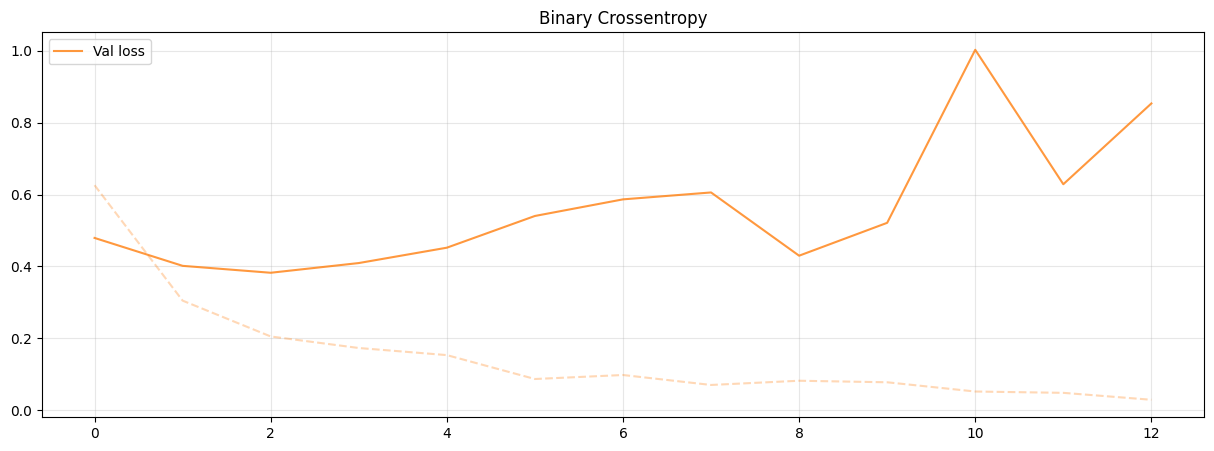

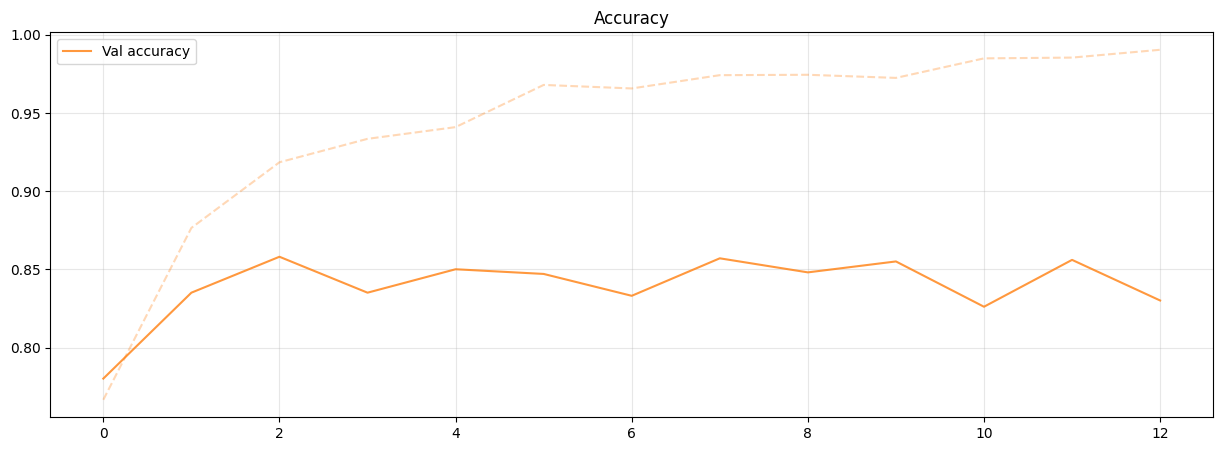

In [ ]:
# plots
plt.figure(figsize=(15,5))
#plt.ylim(-1, 2)
plt.plot(history.history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history.history['val_loss'], label='Val loss', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history.history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history.history['val_accuracy'], label='Val accuracy', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

# Train model: basic model + balanced classes

### Model structure

In [ ]:
xavier_init = tf.keras.initializers.GlorotNormal(seed=seed)

base_model = tf.keras.applications.ConvNeXtBase(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
base_model.trainable = False

model = tfk.Sequential([
        base_model,
        tfkl.Flatten(),
        tfkl.Dense(2048, activation='relu', kernel_initializer=xavier_init),
        tfkl.Dense(1024, activation='relu', kernel_initializer=xavier_init),
        tfkl.Dense(256, activation='relu', kernel_initializer=xavier_init),
        tfkl.Dense(64, activation='relu', kernel_initializer=xavier_init),
        tfkl.Dense(1, activation='sigmoid', kernel_initializer=xavier_init)
    ])

model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer='Adam', metrics=['accuracy', 'Precision','Recall'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convnext_base (Functional)  (None, 3, 3, 1024)        87566464  
                                                                 
 flatten_9 (Flatten)         (None, 9216)              0         
                                                                 
 dense_40 (Dense)            (None, 2048)              18876416  
                                                                 
 dense_41 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_42 (Dense)            (None, 256)               262400    
                                                                 
 dense_43 (Dense)            (None, 64)                16448     
                                                                 
 dense_44 (Dense)            (None, 1)                

### Train the model

In [ ]:
# Compute class weights to balance the train set
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                  classes = np.unique(y_val),
                                                  y =y_val)

class_weights = dict(zip(np.unique(y_clean), class_weights))
class_weights

{0: 0.8300165837479271, 1: 1.2575376884422111}

In [ ]:
### Fit the model
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=10,
    restore_best_weights=True)

history = model.fit(
    X_train,
    y_train,
    batch_size=32, #default parameter
    epochs=200,
    validation_data=(X_val, y_val),
    callbacks = [early_stopping],
    class_weight=class_weights
)

Epoch 1/200
126/126 [==============================] - 48s 207ms/step - loss: 0.6498 - accuracy: 0.7339 - precision: 0.6317 - recall: 0.7010 - val_loss: 0.4450 - val_accuracy: 0.7902 - val_precision: 0.6843 - val_recall: 0.8769
Epoch 2/200
126/126 [==============================] - 15s 119ms/step - loss: 0.3054 - accuracy: 0.8676 - precision: 0.8076 - recall: 0.8505 - val_loss: 0.3933 - val_accuracy: 0.8322 - val_precision: 0.7674 - val_recall: 0.8291
Epoch 3/200
126/126 [==============================] - 12s 99ms/step - loss: 0.2154 - accuracy: 0.9128 - precision: 0.8705 - recall: 0.9023 - val_loss: 0.3482 - val_accuracy: 0.8531 - val_precision: 0.8210 - val_recall: 0.8065
Epoch 4/200
126/126 [==============================] - 12s 93ms/step - loss: 0.1712 - accuracy: 0.9313 - precision: 0.8958 - recall: 0.9249 - val_loss: 0.5272 - val_accuracy: 0.8322 - val_precision: 0.7626 - val_recall: 0.8392
Epoch 5/200
126/126 [==============================] - 12s 93ms/step - loss: 0.1388 - accu

### Performance and plots

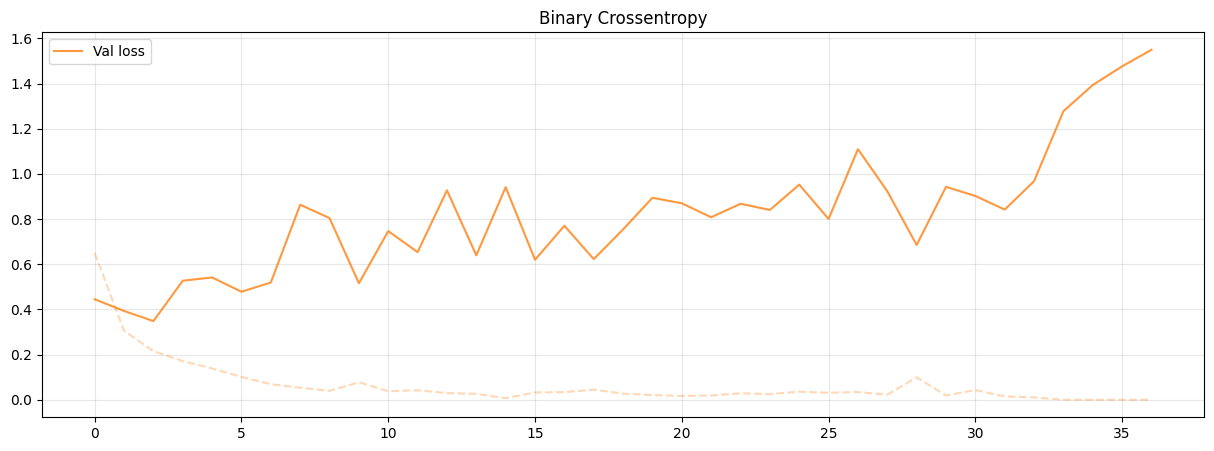

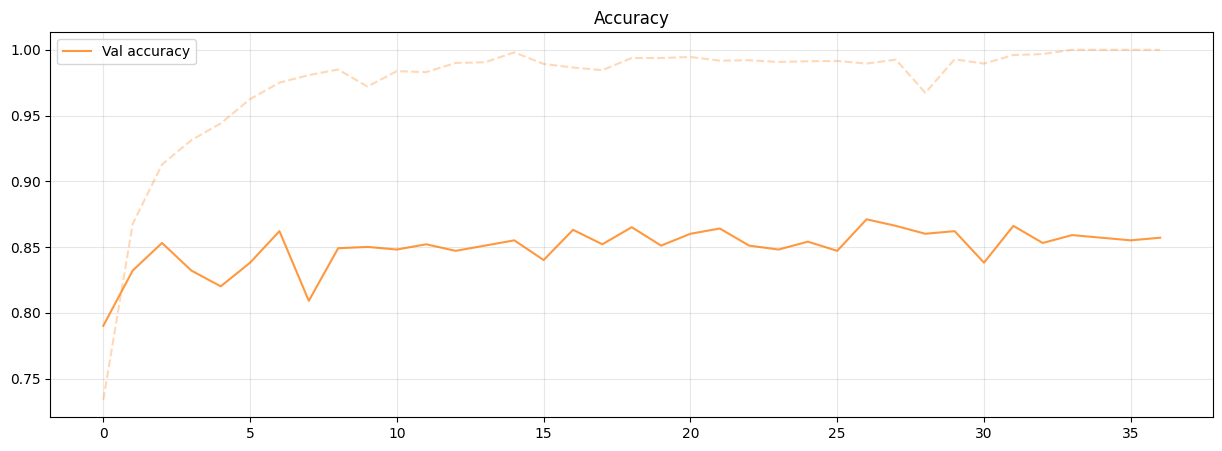

In [ ]:
# plots
plt.figure(figsize=(15,5))
#plt.ylim(-1, 2)
plt.plot(history.history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history.history['val_loss'], label='Val loss', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history.history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history.history['val_accuracy'], label='Val accuracy', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

# Train model: use leaky_relu

### Model structure

In [ ]:
xavier_init = tf.keras.initializers.GlorotNormal(seed=seed)

base_model = tf.keras.applications.ConvNeXtBase(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
base_model.trainable = False

model = tfk.Sequential([
        base_model,
        tfkl.Flatten(),
        tfkl.Dense(2048, activation='leaky_relu', kernel_initializer=xavier_init),
        tfkl.Dense(1024, activation='leaky_relu', kernel_initializer=xavier_init),
        tfkl.Dense(256, activation='leaky_relu', kernel_initializer=xavier_init),
        tfkl.Dense(64, activation='leaky_relu', kernel_initializer=xavier_init),
        tfkl.Dense(1, activation='sigmoid', kernel_initializer=xavier_init)
    ])

model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer='Adam', metrics=['accuracy', 'Precision','Recall'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convnext_base (Functional)  (None, 3, 3, 1024)        87566464  
                                                                 
 flatten_10 (Flatten)        (None, 9216)              0         
                                                                 
 dense_45 (Dense)            (None, 2048)              18876416  
                                                                 
 dense_46 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_47 (Dense)            (None, 256)               262400    
                                                                 
 dense_48 (Dense)            (None, 64)                16448     
                                                                 
 dense_49 (Dense)            (None, 1)                

### Train the model

In [ ]:
# Compute class weights to balance the train set
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                  classes = np.unique(y_val),
                                                  y =y_val)

class_weights = dict(zip(np.unique(y_clean), class_weights))
class_weights

{0: 0.8300165837479271, 1: 1.2575376884422111}

In [ ]:
### Fit the model
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=10,
    restore_best_weights=True)

history = model.fit(
    X_train,
    y_train,
    batch_size=32, #default parameter
    epochs=200,
    validation_data=(X_val, y_val),
    callbacks = [early_stopping],
    class_weight = class_weights
)

Epoch 1/200
126/126 [==============================] - 87s 226ms/step - loss: 0.8869 - accuracy: 0.7167 - precision: 0.6111 - recall: 0.6777 - val_loss: 0.4688 - val_accuracy: 0.7992 - val_precision: 0.7641 - val_recall: 0.7161
Epoch 2/200
126/126 [==============================] - 15s 116ms/step - loss: 0.3504 - accuracy: 0.8514 - precision: 0.7869 - recall: 0.8292 - val_loss: 0.4489 - val_accuracy: 0.8292 - val_precision: 0.8043 - val_recall: 0.7538
Epoch 3/200
126/126 [==============================] - 12s 94ms/step - loss: 0.2489 - accuracy: 0.9006 - precision: 0.8546 - recall: 0.8864 - val_loss: 0.5560 - val_accuracy: 0.7992 - val_precision: 0.6781 - val_recall: 0.9422
Epoch 4/200
126/126 [==============================] - 12s 93ms/step - loss: 0.2467 - accuracy: 0.9001 - precision: 0.8558 - recall: 0.8831 - val_loss: 0.3801 - val_accuracy: 0.8422 - val_precision: 0.8000 - val_recall: 0.8040
Epoch 5/200
126/126 [==============================] - 12s 96ms/step - loss: 0.2589 - accu

### Performance and plots

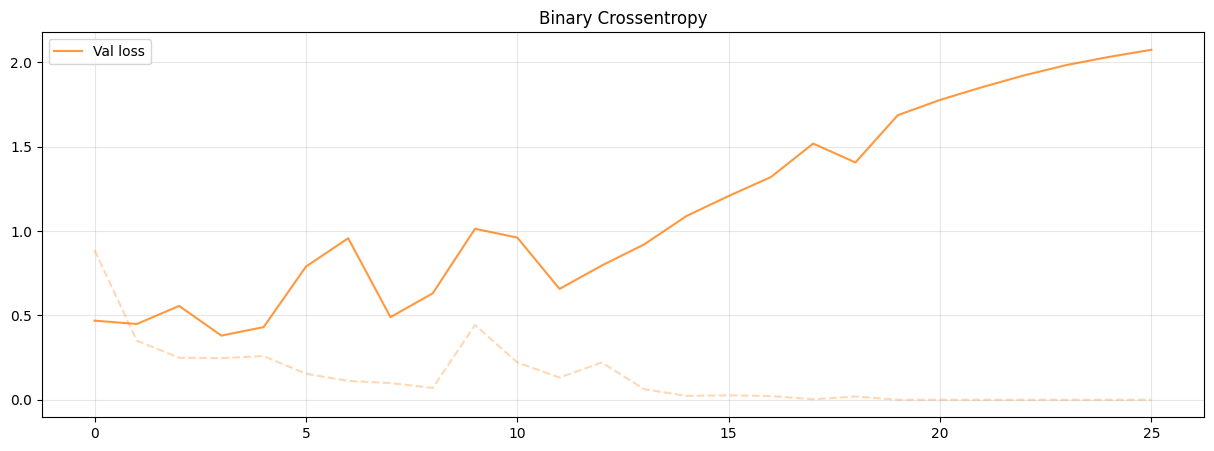

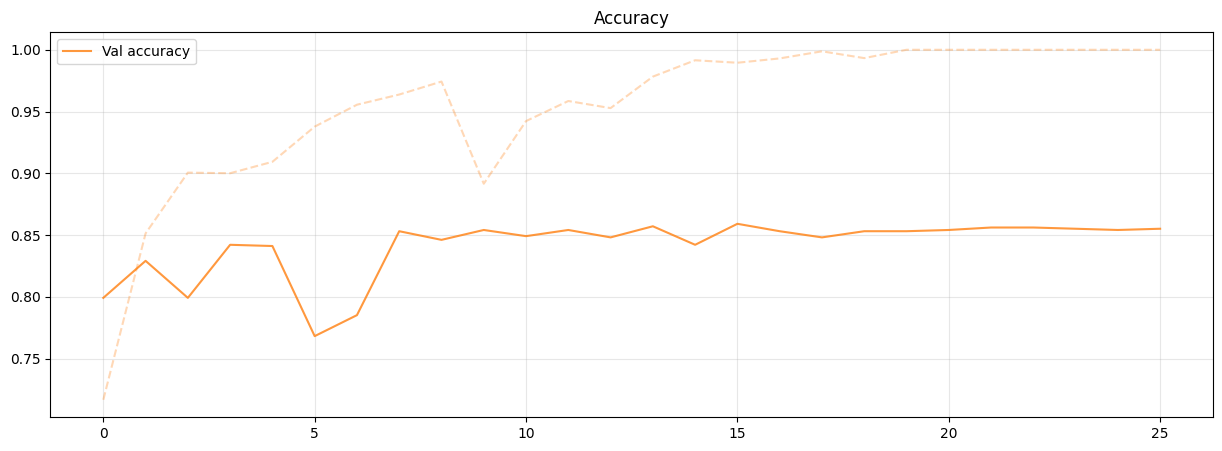

In [ ]:
# plots
plt.figure(figsize=(15,5))
#plt.ylim(-1, 2)
plt.plot(history.history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history.history['val_loss'], label='Val loss', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history.history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history.history['val_accuracy'], label='Val accuracy', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

# Train model: use dropout

### Model structure

In [ ]:
xavier_init = tf.keras.initializers.GlorotNormal(seed=seed)

base_model = tf.keras.applications.ConvNeXtBase(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
base_model.trainable = False

model = tfk.Sequential([
        base_model,
        tfkl.Flatten(),
        tfkl.Dense(2048, activation='leaky_relu', kernel_initializer=xavier_init),
        tfkl.Dropout(0.3),
        tfkl.Dense(1024, activation='leaky_relu', kernel_initializer=xavier_init),
        tfkl.Dropout(0.3),
        tfkl.Dense(256, activation='leaky_relu', kernel_initializer=xavier_init),
        tfkl.Dropout(0.3),
        tfkl.Dense(64, activation='leaky_relu', kernel_initializer=xavier_init),
        tfkl.Dense(1, activation='sigmoid', kernel_initializer=xavier_init)
    ])

model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer='Adam', metrics=['accuracy', 'Precision','Recall'])
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convnext_base (Functional)  (None, 3, 3, 1024)        87566464  
                                                                 
 flatten_15 (Flatten)        (None, 9216)              0         
                                                                 
 dense_66 (Dense)            (None, 2048)              18876416  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_67 (Dense)            (None, 1024)              2098176   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_68 (Dense)            (None, 256)             

### Train the model

In [ ]:
# Compute class weights to balance the train set
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                  classes = np.unique(y_val),
                                                  y =y_val)

class_weights = dict(zip(np.unique(y_clean), class_weights))
class_weights

{0: 0.8300165837479271, 1: 1.2575376884422111}

In [ ]:
### Fit the model
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=10,
    restore_best_weights=True)

history = model.fit(
    X_train,
    y_train,
    batch_size=32, #default parameter
    epochs=200,
    validation_data=(X_val, y_val),
    callbacks = [early_stopping],
    class_weight = class_weights
)

Epoch 1/200
126/126 [==============================] - 54s 223ms/step - loss: 1.0260 - accuracy: 0.6585 - precision: 0.5402 - recall: 0.6159 - val_loss: 0.4535 - val_accuracy: 0.7862 - val_precision: 0.6917 - val_recall: 0.8342
Epoch 2/200
126/126 [==============================] - 13s 100ms/step - loss: 0.5043 - accuracy: 0.7987 - precision: 0.7094 - recall: 0.7867 - val_loss: 0.4041 - val_accuracy: 0.8092 - val_precision: 0.8764 - val_recall: 0.6055
Epoch 3/200
126/126 [==============================] - 12s 92ms/step - loss: 0.3546 - accuracy: 0.8516 - precision: 0.7896 - recall: 0.8252 - val_loss: 0.4539 - val_accuracy: 0.8032 - val_precision: 0.6844 - val_recall: 0.9372
Epoch 4/200
126/126 [==============================] - 13s 102ms/step - loss: 0.3093 - accuracy: 0.8768 - precision: 0.8211 - recall: 0.8598 - val_loss: 0.4458 - val_accuracy: 0.8242 - val_precision: 0.7467 - val_recall: 0.8442
Epoch 5/200
126/126 [==============================] - 13s 104ms/step - loss: 0.3052 - ac

### Performance and plots

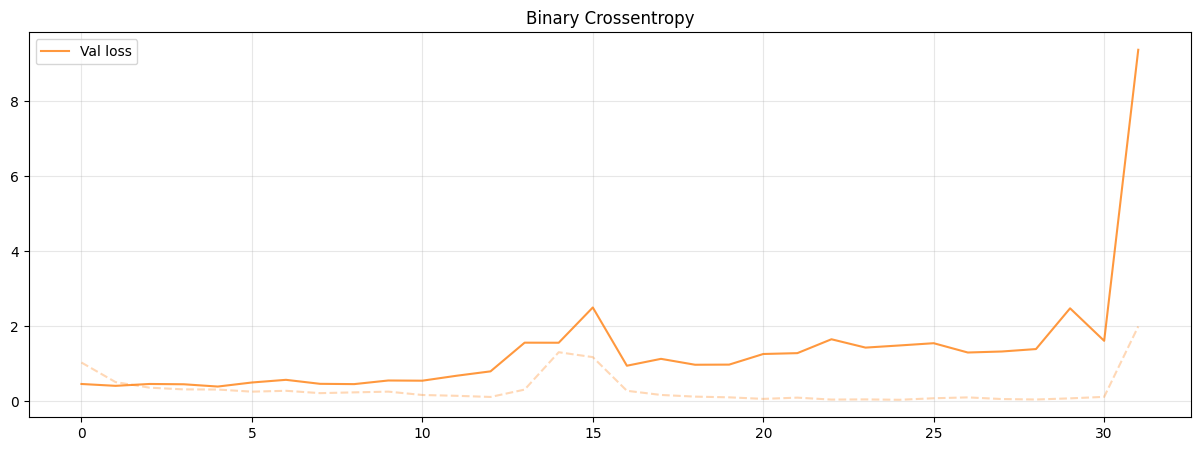

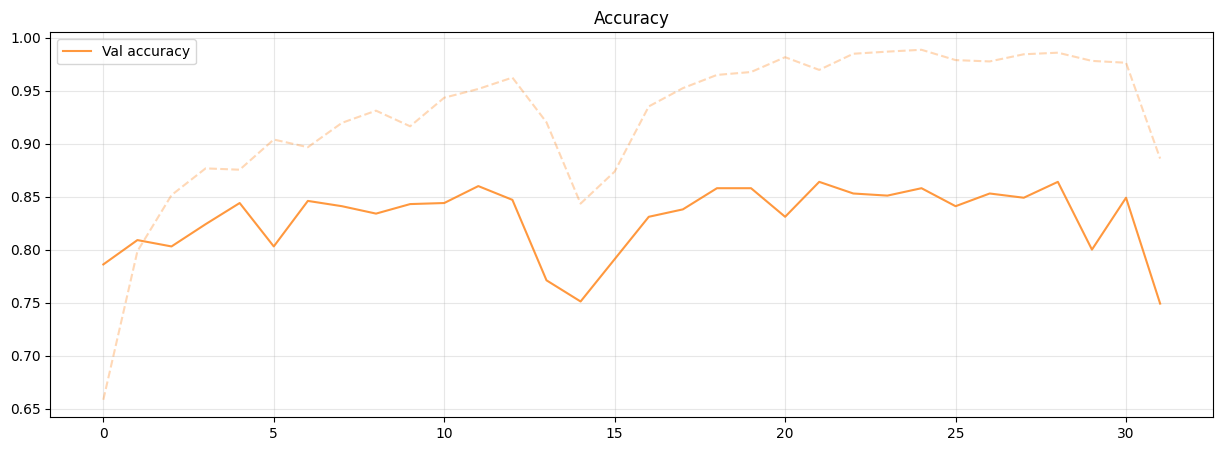

In [ ]:
# plots
plt.figure(figsize=(15,5))
#plt.ylim(-1, 2)
plt.plot(history.history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history.history['val_loss'], label='Val loss', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history.history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history.history['val_accuracy'], label='Val accuracy', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

# Train model: fine tuning

### Model structure

In [ ]:
# Fine tuning
base_model = tf.keras.applications.ConvNeXtBase(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
base_model.trainable = True

N = 260
for i, layer in enumerate(base_model.layers[:N]):
  layer.trainable=False
for i, layer in enumerate(base_model.layers):
   print(i, layer.name, layer.trainable)

0 input_2 False
1 convnext_base_prestem_normalization False
2 convnext_base_stem False
3 convnext_base_stage_0_block_0_depthwise_conv False
4 convnext_base_stage_0_block_0_layernorm False
5 convnext_base_stage_0_block_0_pointwise_conv_1 False
6 convnext_base_stage_0_block_0_gelu False
7 convnext_base_stage_0_block_0_pointwise_conv_2 False
8 convnext_base_stage_0_block_0_layer_scale False
9 convnext_base_stage_0_block_0_identity False
10 tf.__operators__.add_36 False
11 convnext_base_stage_0_block_1_depthwise_conv False
12 convnext_base_stage_0_block_1_layernorm False
13 convnext_base_stage_0_block_1_pointwise_conv_1 False
14 convnext_base_stage_0_block_1_gelu False
15 convnext_base_stage_0_block_1_pointwise_conv_2 False
16 convnext_base_stage_0_block_1_layer_scale False
17 convnext_base_stage_0_block_1_identity False
18 tf.__operators__.add_37 False
19 convnext_base_stage_0_block_2_depthwise_conv False
20 convnext_base_stage_0_block_2_layernorm False
21 convnext_base_stage_0_block_2_po

In [ ]:
xavier_init = tf.keras.initializers.GlorotNormal(seed=seed)

model = tfk.Sequential([
        base_model,
        tfkl.Flatten(),
        tfkl.Dense(2048, activation='leaky_relu', kernel_initializer=xavier_init),
        tfkl.Dropout(0.3),
        tfkl.Dense(1024, activation='leaky_relu', kernel_initializer=xavier_init),
        tfkl.Dropout(0.3),
        tfkl.Dense(256, activation='leaky_relu', kernel_initializer=xavier_init),
        tfkl.Dropout(0.3),
        tfkl.Dense(64, activation='leaky_relu', kernel_initializer=xavier_init),
        tfkl.Dense(1, activation='sigmoid', kernel_initializer=xavier_init)
    ])

model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer='Adam', metrics=['accuracy', 'Precision','Recall'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convnext_base (Functional)  (None, 3, 3, 1024)        87566464  
                                                                 
 flatten_1 (Flatten)         (None, 9216)              0         
                                                                 
 dense_5 (Dense)             (None, 2048)              18876416  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_7 (Dense)             (None, 256)              

### Train the model

In [ ]:
# Compute class weights to balance the train set
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                  classes = np.unique(y_val),
                                                  y =y_val)

class_weights = dict(zip(np.unique(y_clean), class_weights))
class_weights

{0: 0.8300165837479271, 1: 1.2575376884422111}

In [ ]:
### Fit the model
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=10,
    restore_best_weights=True)

history = model.fit(
    X_train,
    y_train,
    batch_size=32, #default parameter
    epochs=200,
    validation_data=(X_val, y_val),
    callbacks = [early_stopping],
    class_weight = class_weights
)

Epoch 1/200
126/126 [==============================] - 67s 310ms/step - loss: 0.6822 - accuracy: 0.7217 - precision: 0.6184 - recall: 0.6784 - val_loss: 0.4054 - val_accuracy: 0.8422 - val_precision: 0.8158 - val_recall: 0.7789
Epoch 2/200
126/126 [==============================] - 26s 209ms/step - loss: 0.3072 - accuracy: 0.8803 - precision: 0.8336 - recall: 0.8518 - val_loss: 0.3428 - val_accuracy: 0.8641 - val_precision: 0.8195 - val_recall: 0.8442
Epoch 3/200
126/126 [==============================] - 25s 200ms/step - loss: 0.2148 - accuracy: 0.9153 - precision: 0.8761 - recall: 0.9023 - val_loss: 0.2786 - val_accuracy: 0.8841 - val_precision: 0.8691 - val_recall: 0.8342
Epoch 4/200
126/126 [==============================] - 25s 198ms/step - loss: 0.1518 - accuracy: 0.9443 - precision: 0.9184 - recall: 0.9349 - val_loss: 0.5425 - val_accuracy: 0.8242 - val_precision: 0.7256 - val_recall: 0.8970
Epoch 5/200
126/126 [==============================] - 25s 196ms/step - loss: 0.1269 - a

### Performance and plots

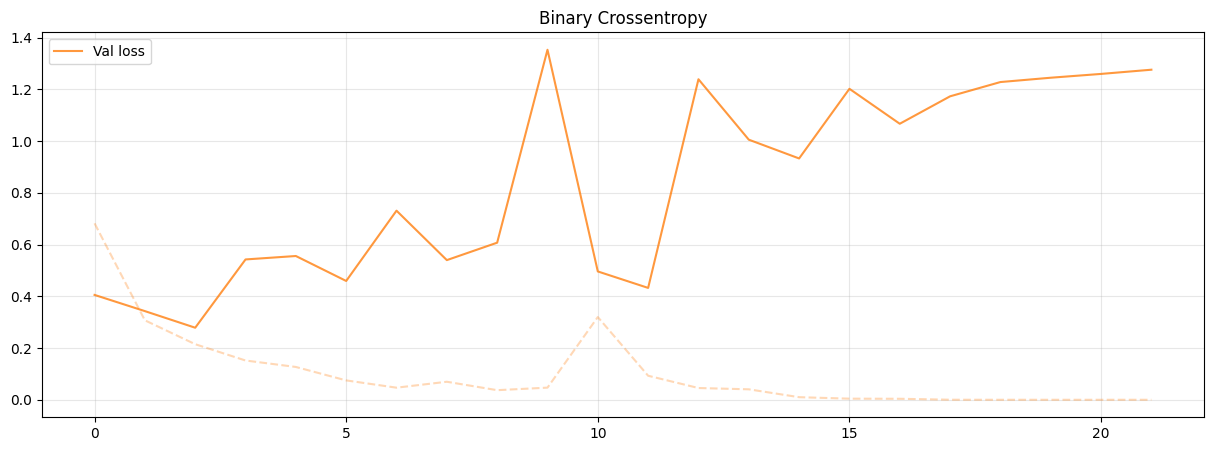

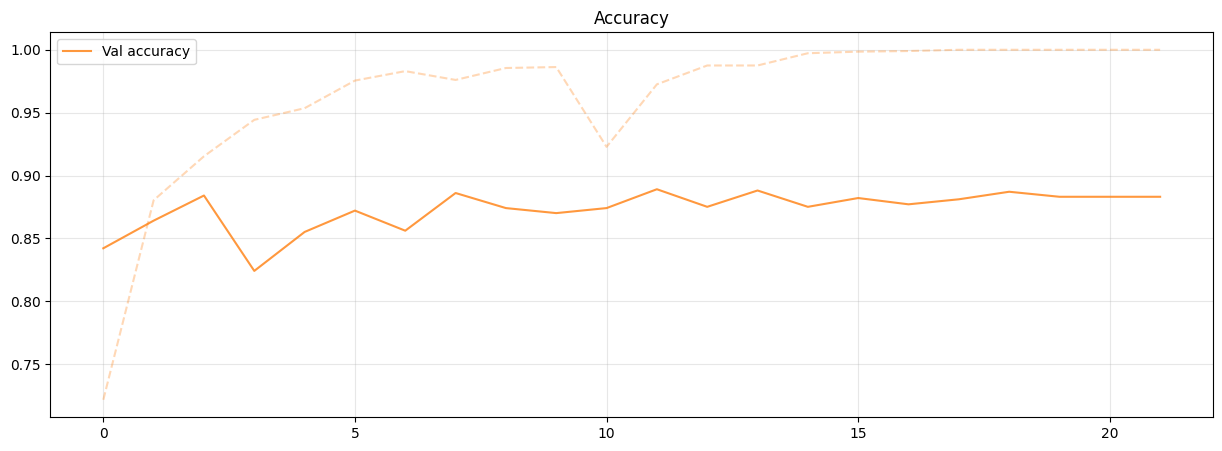

In [ ]:
# plots
plt.figure(figsize=(15,5))
#plt.ylim(-1, 2)
plt.plot(history.history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history.history['val_loss'], label='Val loss', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history.history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history.history['val_accuracy'], label='Val accuracy', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

# Train model: regularization

### Model structure

In [ ]:
# Fine tuning
base_model = tf.keras.applications.ConvNeXtBase(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
base_model.trainable = True

N = 260
for i, layer in enumerate(base_model.layers[:N]):
  layer.trainable=False
for i, layer in enumerate(base_model.layers):
   print(i, layer.name, layer.trainable)

0 input_3 False
1 convnext_base_prestem_normalization False
2 convnext_base_stem False
3 convnext_base_stage_0_block_0_depthwise_conv False
4 convnext_base_stage_0_block_0_layernorm False
5 convnext_base_stage_0_block_0_pointwise_conv_1 False
6 convnext_base_stage_0_block_0_gelu False
7 convnext_base_stage_0_block_0_pointwise_conv_2 False
8 convnext_base_stage_0_block_0_layer_scale False
9 convnext_base_stage_0_block_0_identity False
10 tf.__operators__.add_50 False
11 convnext_base_stage_0_block_1_depthwise_conv False
12 convnext_base_stage_0_block_1_layernorm False
13 convnext_base_stage_0_block_1_pointwise_conv_1 False
14 convnext_base_stage_0_block_1_gelu False
15 convnext_base_stage_0_block_1_pointwise_conv_2 False
16 convnext_base_stage_0_block_1_layer_scale False
17 convnext_base_stage_0_block_1_identity False
18 tf.__operators__.add_51 False
19 convnext_base_stage_0_block_2_depthwise_conv False
20 convnext_base_stage_0_block_2_layernorm False
21 convnext_base_stage_0_block_2_po

In [ ]:
xavier_init = tf.keras.initializers.GlorotNormal(seed=seed)
ridge = tfk.regularizers.l2(0.01)

model = tfk.Sequential([
        base_model,
        tfkl.Flatten(),
        tfkl.Dense(2048, activation='leaky_relu', kernel_initializer=xavier_init, kernel_regularizer = ridge),
        tfkl.Dropout(0.3),
        tfkl.Dense(1024, activation='leaky_relu', kernel_initializer=xavier_init, kernel_regularizer = ridge),
        tfkl.Dropout(0.3),
        tfkl.Dense(256, activation='leaky_relu', kernel_initializer=xavier_init, kernel_regularizer = ridge),
        tfkl.Dropout(0.3),
        tfkl.Dense(64, activation='leaky_relu', kernel_initializer=xavier_init, kernel_regularizer = ridge),
        tfkl.Dense(1, activation='sigmoid', kernel_initializer=xavier_init)
    ])

model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer='Adam', metrics=['accuracy', 'Precision','Recall'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convnext_base (Functional)  (None, 3, 3, 1024)        87566464  
                                                                 
 flatten_1 (Flatten)         (None, 9216)              0         
                                                                 
 dense_5 (Dense)             (None, 2048)              18876416  
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_7 (Dense)             (None, 256)              

### Train the model

In [ ]:
# Compute class weights to balance the train set
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                  classes = np.unique(y_val),
                                                  y =y_val)

class_weights = dict(zip(np.unique(y_clean), class_weights))
class_weights

{0: 0.8300165837479271, 1: 1.2575376884422111}

In [ ]:
### Fit the model
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=10,
    restore_best_weights=True)

history = model.fit(
    X_train,
    y_train,
    batch_size=32, #default parameter
    epochs=200,
    validation_data=(X_val, y_val),
    callbacks = [early_stopping],
    class_weight = class_weights
)

Epoch 1/200
126/126 [==============================] - 27s 212ms/step - loss: 1.4658 - accuracy: 0.8961 - precision: 0.8552 - recall: 0.8711 - val_loss: 1.1059 - val_accuracy: 0.8821 - val_precision: 0.8763 - val_recall: 0.8191
Epoch 2/200
126/126 [==============================] - 26s 203ms/step - loss: 0.7684 - accuracy: 0.9350 - precision: 0.9114 - recall: 0.9163 - val_loss: 0.8426 - val_accuracy: 0.8661 - val_precision: 0.8014 - val_recall: 0.8819
Epoch 3/200
126/126 [==============================] - 25s 201ms/step - loss: 0.4978 - accuracy: 0.9455 - precision: 0.9220 - recall: 0.9342 - val_loss: 0.5615 - val_accuracy: 0.9081 - val_precision: 0.8732 - val_recall: 0.8995
Epoch 4/200
126/126 [==============================] - 25s 202ms/step - loss: 0.3458 - accuracy: 0.9613 - precision: 0.9447 - recall: 0.9528 - val_loss: 0.6837 - val_accuracy: 0.8681 - val_precision: 0.8260 - val_recall: 0.8467
Epoch 5/200
126/126 [==============================] - 26s 204ms/step - loss: 0.2272 - a

### Performance and plots

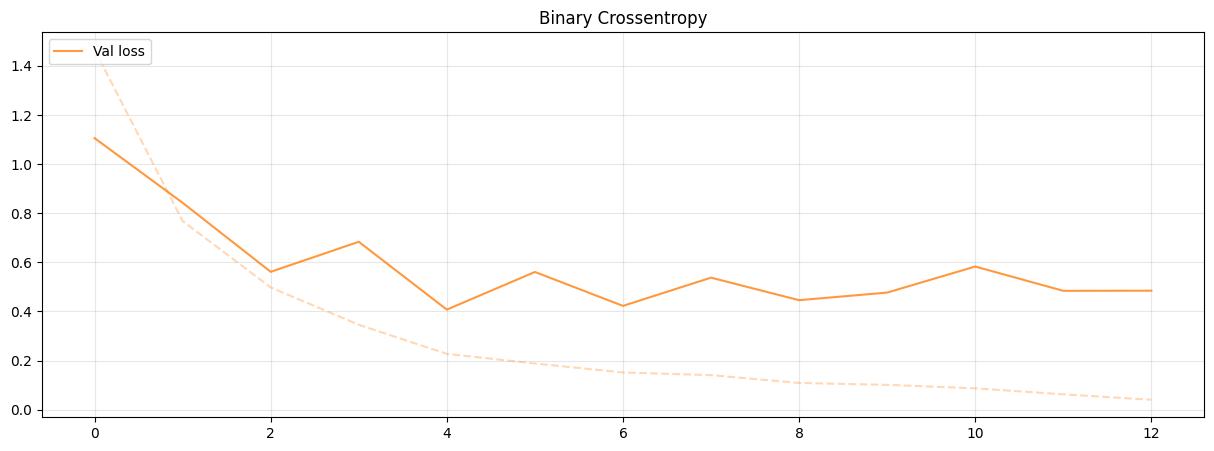

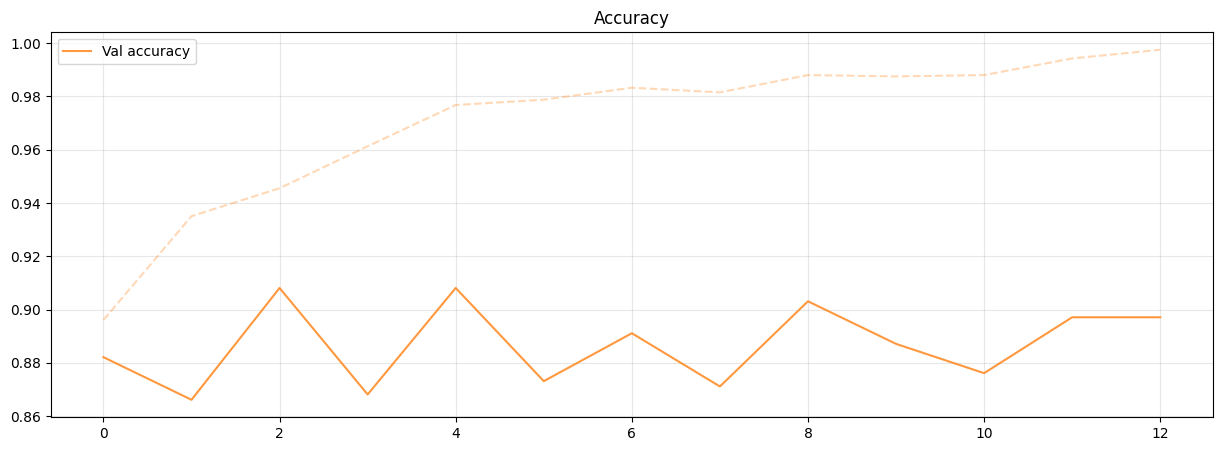

In [ ]:
# plots
plt.figure(figsize=(15,5))
#plt.ylim(-1, 2)
plt.plot(history.history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history.history['val_loss'], label='Val loss', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history.history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history.history['val_accuracy'], label='Val accuracy', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

# Train model: batch normalization

### Model structure

In [ ]:
# Fine tuning
base_model = tf.keras.applications.ConvNeXtBase(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
base_model.trainable = True

N = 260
for i, layer in enumerate(base_model.layers[:N]):
  layer.trainable=False
for i, layer in enumerate(base_model.layers):
   print(i, layer.name, layer.trainable)

0 input_4 False
1 convnext_base_prestem_normalization False
2 convnext_base_stem False
3 convnext_base_stage_0_block_0_depthwise_conv False
4 convnext_base_stage_0_block_0_layernorm False
5 convnext_base_stage_0_block_0_pointwise_conv_1 False
6 convnext_base_stage_0_block_0_gelu False
7 convnext_base_stage_0_block_0_pointwise_conv_2 False
8 convnext_base_stage_0_block_0_layer_scale False
9 convnext_base_stage_0_block_0_identity False
10 tf.__operators__.add_86 False
11 convnext_base_stage_0_block_1_depthwise_conv False
12 convnext_base_stage_0_block_1_layernorm False
13 convnext_base_stage_0_block_1_pointwise_conv_1 False
14 convnext_base_stage_0_block_1_gelu False
15 convnext_base_stage_0_block_1_pointwise_conv_2 False
16 convnext_base_stage_0_block_1_layer_scale False
17 convnext_base_stage_0_block_1_identity False
18 tf.__operators__.add_87 False
19 convnext_base_stage_0_block_2_depthwise_conv False
20 convnext_base_stage_0_block_2_layernorm False
21 convnext_base_stage_0_block_2_po

In [ ]:
xavier_init = tf.keras.initializers.GlorotNormal(seed=seed)
ridge = tfk.regularizers.l2(0.01)

model = tfk.Sequential([
        base_model,
        tfkl.Flatten(),
        tfkl.Dense(2048, activation='leaky_relu', kernel_initializer=xavier_init, kernel_regularizer = ridge),
        tfkl.Dropout(0.3),
        tfkl.BatchNormalization(),
        tfkl.Dense(1024, activation='leaky_relu', kernel_initializer=xavier_init, kernel_regularizer = ridge),
        tfkl.Dropout(0.3),
        tfkl.BatchNormalization(),
        tfkl.Dense(256, activation='leaky_relu', kernel_initializer=xavier_init, kernel_regularizer = ridge),
        tfkl.Dropout(0.3),
        tfkl.BatchNormalization(),
        tfkl.Dense(64, activation='leaky_relu', kernel_initializer=xavier_init, kernel_regularizer = ridge),
        tfkl.Dense(1, activation='sigmoid', kernel_initializer=xavier_init)
    ])

model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer='Adam', metrics=['accuracy', 'Precision','Recall'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convnext_base (Functional)  (None, 3, 3, 1024)        87566464  
                                                                 
 flatten_2 (Flatten)         (None, 9216)              0         
                                                                 
 dense_10 (Dense)            (None, 2048)              18876416  
                                                                 
 dropout_6 (Dropout)         (None, 2048)              0         
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense_11 (Dense)            (None, 1024)              2098176   
                                                      

### Train the model

In [ ]:
# Compute class weights to balance the train set
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                  classes = np.unique(y_val),
                                                  y =y_val)

class_weights = dict(zip(np.unique(y_clean), class_weights))
class_weights

{0: 0.8300165837479271, 1: 1.2575376884422111}

In [ ]:
### Fit the model
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=10,
    restore_best_weights=True)

history = model.fit(
    X_train,
    y_train,
    batch_size=32, #default parameter
    epochs=200,
    validation_data=(X_val, y_val),
    callbacks = [early_stopping],
    class_weight = class_weights
)

Epoch 1/200
126/126 [==============================] - 72s 322ms/step - loss: 15.8026 - accuracy: 0.8061 - precision: 0.7240 - recall: 0.7827 - val_loss: 2.4522 - val_accuracy: 0.8511 - val_precision: 0.8716 - val_recall: 0.7337
Epoch 2/200
126/126 [==============================] - 26s 205ms/step - loss: 1.2520 - accuracy: 0.8918 - precision: 0.8512 - recall: 0.8631 - val_loss: 0.9065 - val_accuracy: 0.8362 - val_precision: 0.9398 - val_recall: 0.6281
Epoch 3/200
126/126 [==============================] - 29s 234ms/step - loss: 0.7838 - accuracy: 0.9156 - precision: 0.8872 - recall: 0.8884 - val_loss: 0.8078 - val_accuracy: 0.8771 - val_precision: 0.8062 - val_recall: 0.9095
Epoch 4/200
126/126 [==============================] - 26s 210ms/step - loss: 0.5511 - accuracy: 0.9323 - precision: 0.8940 - recall: 0.9302 - val_loss: 0.6311 - val_accuracy: 0.8751 - val_precision: 0.8660 - val_recall: 0.8116
Epoch 5/200
126/126 [==============================] - 25s 198ms/step - loss: 0.3914 - 

### Performance and plots

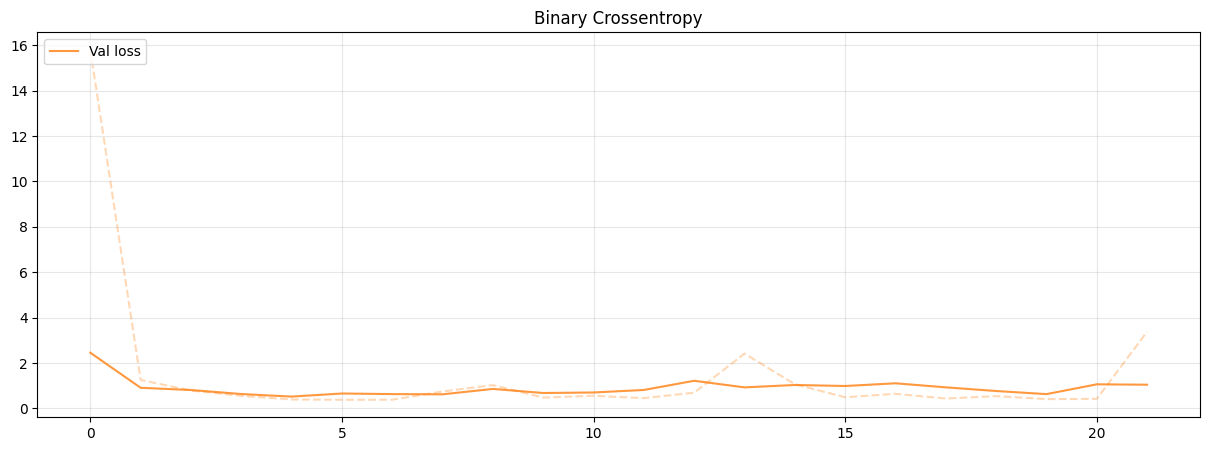

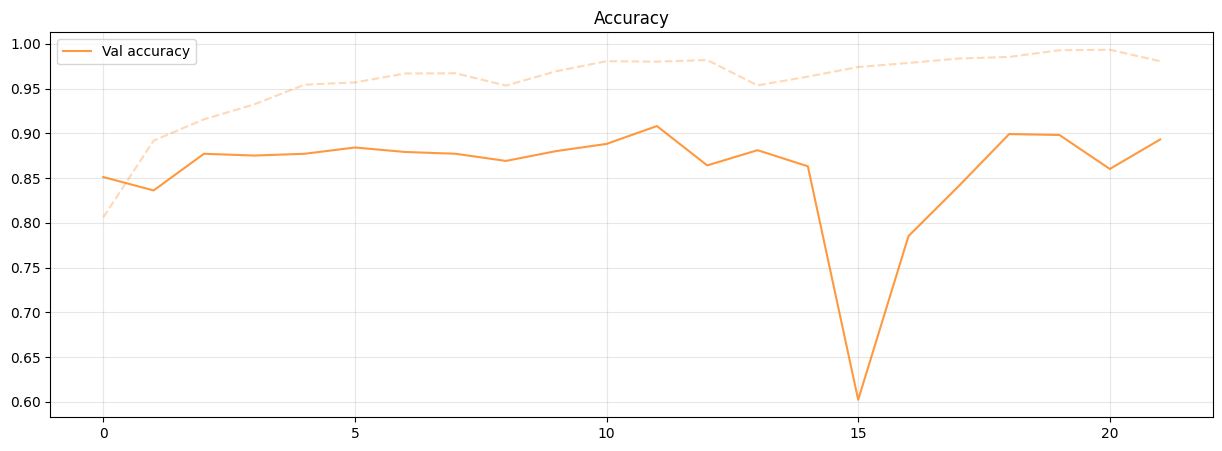

In [ ]:
# plots
plt.figure(figsize=(15,5))
#plt.ylim(-1, 2)
plt.plot(history.history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history.history['val_loss'], label='Val loss', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history.history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history.history['val_accuracy'], label='Val accuracy', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

# Train model: learning rate scheduling

### Model structure

In [ ]:
# Fine tuning
base_model = tf.keras.applications.ConvNeXtBase(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
base_model.trainable = True

N = 260
for i, layer in enumerate(base_model.layers[:N]):
  layer.trainable=False
for i, layer in enumerate(base_model.layers):
   print(i, layer.name, layer.trainable)

0 input_5 False
1 convnext_base_prestem_normalization False
2 convnext_base_stem False
3 convnext_base_stage_0_block_0_depthwise_conv False
4 convnext_base_stage_0_block_0_layernorm False
5 convnext_base_stage_0_block_0_pointwise_conv_1 False
6 convnext_base_stage_0_block_0_gelu False
7 convnext_base_stage_0_block_0_pointwise_conv_2 False
8 convnext_base_stage_0_block_0_layer_scale False
9 convnext_base_stage_0_block_0_identity False
10 tf.__operators__.add_122 False
11 convnext_base_stage_0_block_1_depthwise_conv False
12 convnext_base_stage_0_block_1_layernorm False
13 convnext_base_stage_0_block_1_pointwise_conv_1 False
14 convnext_base_stage_0_block_1_gelu False
15 convnext_base_stage_0_block_1_pointwise_conv_2 False
16 convnext_base_stage_0_block_1_layer_scale False
17 convnext_base_stage_0_block_1_identity False
18 tf.__operators__.add_123 False
19 convnext_base_stage_0_block_2_depthwise_conv False
20 convnext_base_stage_0_block_2_layernorm False
21 convnext_base_stage_0_block_2_

In [ ]:
xavier_init = tf.keras.initializers.GlorotNormal(seed=seed)
ridge = tfk.regularizers.l2(0.01)

model = tfk.Sequential([
        base_model,
        tfkl.Flatten(),
        tfkl.Dense(2048, activation='leaky_relu', kernel_initializer=xavier_init, kernel_regularizer = ridge),
        tfkl.Dropout(0.3),
        tfkl.BatchNormalization(),
        tfkl.Dense(1024, activation='leaky_relu', kernel_initializer=xavier_init, kernel_regularizer = ridge),
        tfkl.Dropout(0.3),
        tfkl.BatchNormalization(),
        tfkl.Dense(256, activation='leaky_relu', kernel_initializer=xavier_init, kernel_regularizer = ridge),
        tfkl.Dropout(0.3),
        tfkl.BatchNormalization(),
        tfkl.Dense(64, activation='leaky_relu', kernel_initializer=xavier_init, kernel_regularizer = ridge),
        tfkl.Dense(1, activation='sigmoid', kernel_initializer=xavier_init)
    ])

model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer='Adam', metrics=['accuracy', 'Precision','Recall'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convnext_base (Functional)  (None, 3, 3, 1024)        87566464  
                                                                 
 flatten_5 (Flatten)         (None, 9216)              0         
                                                                 
 dense_25 (Dense)            (None, 2048)              18876416  
                                                                 
 dropout_15 (Dropout)        (None, 2048)              0         
                                                                 
 batch_normalization_9 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dense_26 (Dense)            (None, 1024)              2098176   
                                                      

### Train the model

In [ ]:
# Compute class weights to balance the train set
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                  classes = np.unique(y_val),
                                                  y =y_val)

class_weights = dict(zip(np.unique(y_clean), class_weights))
class_weights

{0: 0.8300165837479271, 1: 1.2575376884422111}

In [ ]:
### Fit the model
lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',# Metric to monitor (validation mean squared error in this case)
   patience=5,            # Number of epochs with no improvement after which learning rate will be reduced
   factor=0.999,          # Factor by which the learning rate will be reduced (0.999 in this case)
   mode='max',            # Mode to decide when to reduce learning rate ('min' means reduce when metric stops decreasing)
   min_lr=1e-5            # Minimum learning rate
)

early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=10,
    restore_best_weights=True)

history = model.fit(
    X_train,
    y_train,
    batch_size=32, #default parameter
    epochs=200,
    validation_data=(X_val, y_val),
    callbacks = [early_stopping, lr_scheduler],
    class_weight = class_weights
)

Epoch 1/200
126/126 [==============================] - 83s 238ms/step - loss: 7.7449 - accuracy: 0.9938 - precision: 0.9914 - recall: 0.9920 - val_loss: 0.8403 - val_accuracy: 0.8951 - val_precision: 0.8463 - val_recall: 0.8995 - lr: 0.0010
Epoch 2/200
126/126 [==============================] - 24s 194ms/step - loss: 0.5452 - accuracy: 0.9878 - precision: 0.9815 - recall: 0.9860 - val_loss: 0.9856 - val_accuracy: 0.8811 - val_precision: 0.9346 - val_recall: 0.7538 - lr: 0.0010
Epoch 3/200
126/126 [==============================] - 25s 199ms/step - loss: 0.5067 - accuracy: 0.9900 - precision: 0.9835 - recall: 0.9900 - val_loss: 1.6336 - val_accuracy: 0.8851 - val_precision: 0.8426 - val_recall: 0.8744 - lr: 0.0010
Epoch 4/200
126/126 [==============================] - 24s 195ms/step - loss: 0.4240 - accuracy: 0.9935 - precision: 0.9914 - recall: 0.9914 - val_loss: 0.6371 - val_accuracy: 0.8981 - val_precision: 0.8895 - val_recall: 0.8492 - lr: 0.0010
Epoch 5/200
126/126 [===============

### Performance and plots

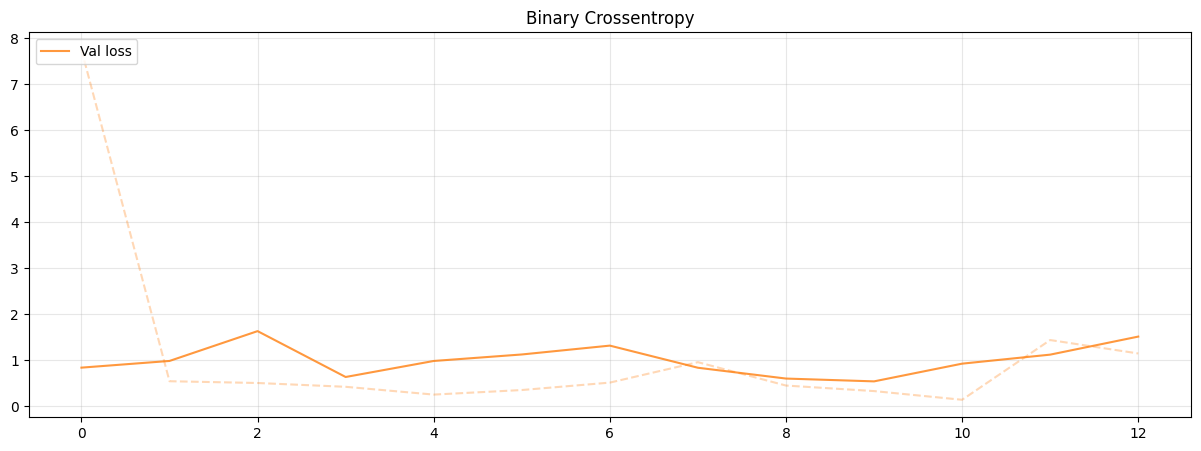

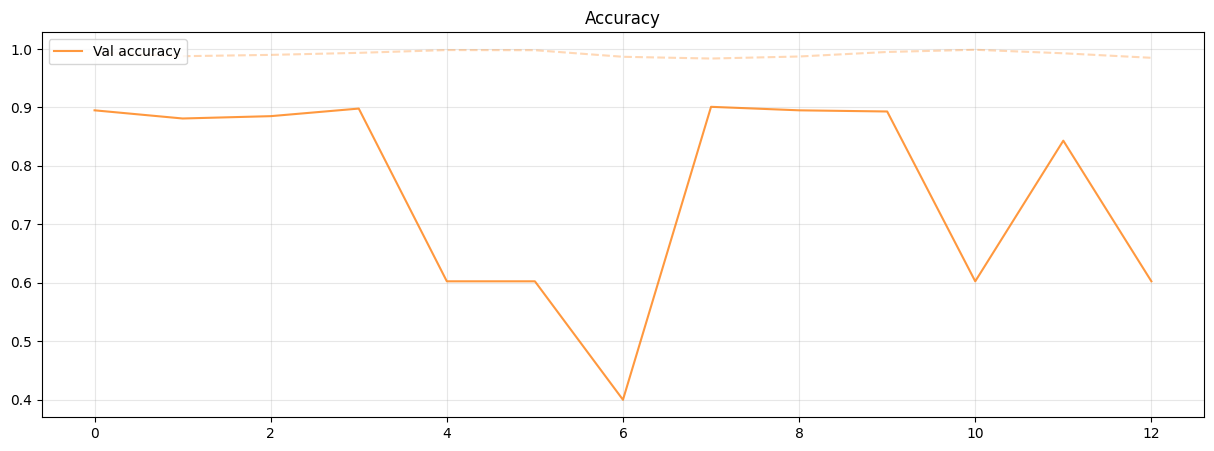

In [ ]:
# plots
plt.figure(figsize=(15,5))
#plt.ylim(-1, 2)
plt.plot(history.history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history.history['val_loss'], label='Val loss', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history.history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history.history['val_accuracy'], label='Val accuracy', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

# Train model: data augmentation

### Model structure

In [ ]:
# Fine tuning
base_model = tf.keras.applications.ConvNeXtBase(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
base_model.trainable = True

N = 260
for i, layer in enumerate(base_model.layers[:N]):
  layer.trainable=False
for i, layer in enumerate(base_model.layers):
   print(i, layer.name, layer.trainable)

0 input_1 False
1 convnext_base_prestem_normalization False
2 convnext_base_stem False
3 convnext_base_stage_0_block_0_depthwise_conv False
4 convnext_base_stage_0_block_0_layernorm False
5 convnext_base_stage_0_block_0_pointwise_conv_1 False
6 convnext_base_stage_0_block_0_gelu False
7 convnext_base_stage_0_block_0_pointwise_conv_2 False
8 convnext_base_stage_0_block_0_layer_scale False
9 convnext_base_stage_0_block_0_identity False
10 tf.__operators__.add False
11 convnext_base_stage_0_block_1_depthwise_conv False
12 convnext_base_stage_0_block_1_layernorm False
13 convnext_base_stage_0_block_1_pointwise_conv_1 False
14 convnext_base_stage_0_block_1_gelu False
15 convnext_base_stage_0_block_1_pointwise_conv_2 False
16 convnext_base_stage_0_block_1_layer_scale False
17 convnext_base_stage_0_block_1_identity False
18 tf.__operators__.add_1 False
19 convnext_base_stage_0_block_2_depthwise_conv False
20 convnext_base_stage_0_block_2_layernorm False
21 convnext_base_stage_0_block_2_pointw

In [ ]:
xavier_init = tf.keras.initializers.GlorotNormal(seed=seed)
ridge = tfk.regularizers.l2(0.01)

model = tfk.Sequential([
        tfkl.RandomZoom(0.3),
        tfkl.RandomFlip('vertical'),
        tfkl.RandomContrast(0.3),
        tfkl.RandomRotation(0.3, fill_mode="reflect", interpolation="bilinear"),
        base_model,
        tfkl.Flatten(),
        tfkl.Dense(2048, activation='leaky_relu', kernel_initializer=xavier_init, kernel_regularizer = ridge),
        tfkl.Dropout(0.3),
        tfkl.BatchNormalization(),
        tfkl.Dense(1024, activation='leaky_relu', kernel_initializer=xavier_init, kernel_regularizer = ridge),
        tfkl.Dropout(0.3),
        tfkl.BatchNormalization(),
        tfkl.Dense(256, activation='leaky_relu', kernel_initializer=xavier_init, kernel_regularizer = ridge),
        tfkl.Dropout(0.3),
        tfkl.BatchNormalization(),
        tfkl.Dense(64, activation='leaky_relu', kernel_initializer=xavier_init, kernel_regularizer = ridge),
        tfkl.Dense(1, activation='sigmoid', kernel_initializer=xavier_init)
    ])

model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer='Adam', metrics=['accuracy', 'Precision','Recall'])

### Train the model

In [ ]:
# Compute class weights to balance the train set
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                  classes = np.unique(y_val),
                                                  y =y_val)

class_weights = dict(zip(np.unique(y_clean), class_weights))
class_weights

{0: 0.8300165837479271, 1: 1.2575376884422111}

In [ ]:
### Fit the model
lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',# Metric to monitor (validation mean squared error in this case)
   patience=5,            # Number of epochs with no improvement after which learning rate will be reduced
   factor=0.999,          # Factor by which the learning rate will be reduced (0.999 in this case)
   mode='max',            # Mode to decide when to reduce learning rate ('min' means reduce when metric stops decreasing)
   min_lr=1e-5            # Minimum learning rate
)

early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=10,
    restore_best_weights=True)

history = model.fit(
    X_train,
    y_train,
    batch_size=32, #default parameter
    epochs=200,
    validation_data=(X_val, y_val),
    callbacks = [early_stopping, lr_scheduler],
    class_weight = class_weights
)

Epoch 1/200
126/126 [==============================] - 95s 393ms/step - loss: 16.7154 - accuracy: 0.7697 - precision: 0.6747 - recall: 0.7482 - val_loss: 3.2262 - val_accuracy: 0.7902 - val_precision: 0.8950 - val_recall: 0.5352 - lr: 0.0010
Epoch 2/200
126/126 [==============================] - 27s 213ms/step - loss: 1.7368 - accuracy: 0.8334 - precision: 0.7735 - recall: 0.7874 - val_loss: 1.0791 - val_accuracy: 0.8312 - val_precision: 0.7189 - val_recall: 0.9447 - lr: 0.0010
Epoch 3/200
126/126 [==============================] - 26s 209ms/step - loss: 0.8792 - accuracy: 0.8431 - precision: 0.7802 - recall: 0.8113 - val_loss: 0.8156 - val_accuracy: 0.8432 - val_precision: 0.7516 - val_recall: 0.9045 - lr: 0.0010
Epoch 4/200
126/126 [==============================] - 31s 247ms/step - loss: 0.9740 - accuracy: 0.8514 - precision: 0.7978 - recall: 0.8100 - val_loss: 0.6329 - val_accuracy: 0.8811 - val_precision: 0.8908 - val_recall: 0.7990 - lr: 0.0010
Epoch 5/200
126/126 [==============

In [ ]:
model.save('data_augmentation_3')

### Performance and plots

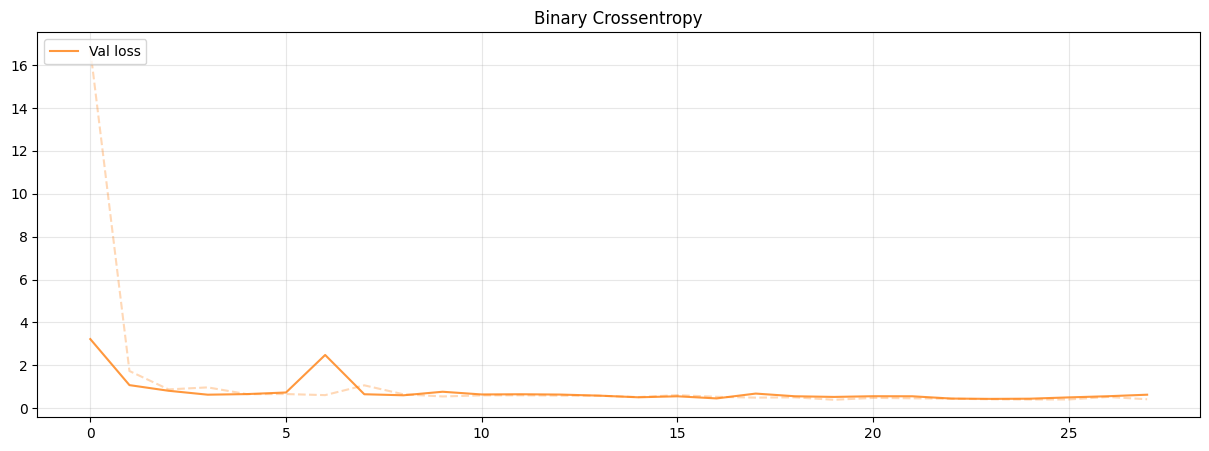

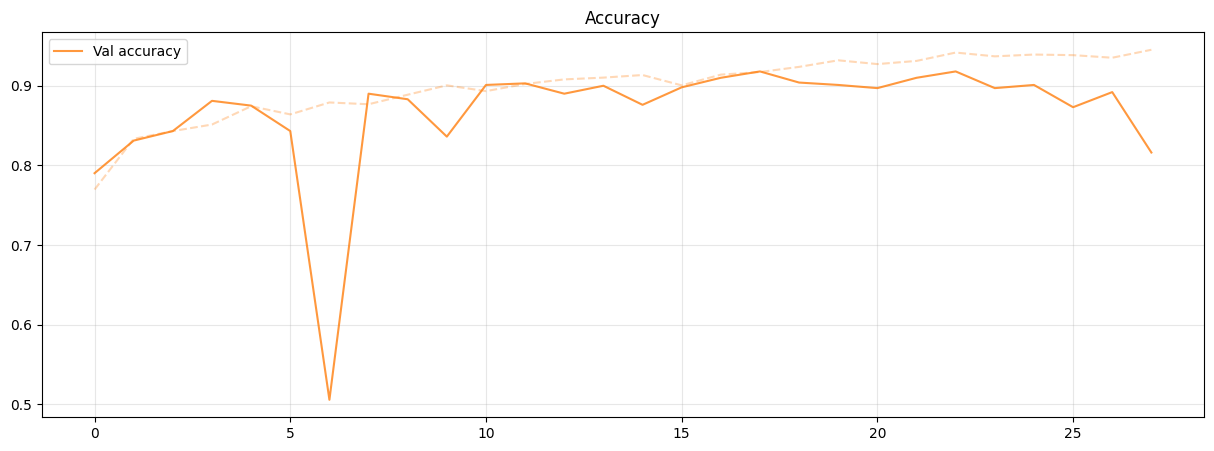

In [ ]:
# plots
plt.figure(figsize=(15,5))
#plt.ylim(-1, 2)
plt.plot(history.history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history.history['val_loss'], label='Val loss', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history.history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history.history['val_accuracy'], label='Val accuracy', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

# Train model: final model (more fine tuning)

### Model structure

In [ ]:
# Fine tuning
base_model = tf.keras.applications.ConvNeXtBase(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
base_model.trainable = True

N = 205
for i, layer in enumerate(base_model.layers[:N]):
  layer.trainable=False
for i, layer in enumerate(base_model.layers):
   print(i, layer.name, layer.trainable)

350926856/350926856 ━━━━━━━━━━━━━━━━━━━━ 16s 0us/step
0 input_layer False
1 convnext_base_prestem_normalization False
2 convnext_base_stem False
3 convnext_base_stage_0_block_0_depthwise_conv False
4 convnext_base_stage_0_block_0_layernorm False
5 convnext_base_stage_0_block_0_pointwise_conv_1 False
6 convnext_base_stage_0_block_0_gelu False
7 convnext_base_stage_0_block_0_pointwise_conv_2 False
8 convnext_base_stage_0_block_0_layer_scale False
9 convnext_base_stage_0_block_0_identity False
10 convnext_base_stage_0_block_1_depthwise_conv False
11 convnext_base_stage_0_block_1_layernorm False
12 convnext_base_stage_0_block_1_pointwise_conv_1 False
13 convnext_base_stage_0_block_1_gelu False
14 convnext_base_stage_0_block_1_pointwise_conv_2 False
15 convnext_base_stage_0_block_1_layer_scale False
16 convnext_base_stage_0_block_1_identity False
17 convnext_base_stage_0_block_2_depthwise_conv False
18 convnext_base_stage_0_block_2_layernorm False
19 convnext_base_stage_0_block_2_pointwise_

In [ ]:
xavier_init = tf.keras.initializers.GlorotNormal(seed=seed)
ridge = tfk.regularizers.l2(0.01)

model = tfk.Sequential([
        tfkl.RandomZoom(0.3),
        tfkl.RandomFlip('vertical'),
        tfkl.RandomContrast(0.3),
        tfkl.RandomRotation(0.3, fill_mode="reflect", interpolation="bilinear"),
        base_model,
        tfkl.Flatten(),
        tfkl.Dense(2048, activation='leaky_relu', kernel_initializer=xavier_init, kernel_regularizer = ridge),
        tfkl.Dropout(0.3),
        tfkl.BatchNormalization(),
        tfkl.Dense(1024, activation='leaky_relu', kernel_initializer=xavier_init, kernel_regularizer = ridge),
        tfkl.Dropout(0.3),
        tfkl.BatchNormalization(),
        tfkl.Dense(256, activation='leaky_relu', kernel_initializer=xavier_init, kernel_regularizer = ridge),
        tfkl.Dropout(0.3),
        tfkl.BatchNormalization(),
        tfkl.Dense(64, activation='relu', kernel_initializer=xavier_init, kernel_regularizer = ridge),
        tfkl.Dense(1, activation='sigmoid', kernel_initializer=xavier_init)
    ])

model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer='Adamax', metrics=['accuracy', 'Precision','Recall'])

### Train the model

In [ ]:
# Compute class weights to balance the train set
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                  classes = np.unique(y_val),
                                                  y =y_val)

class_weights = dict(zip(np.unique(y_clean), class_weights))
class_weights

{0: 0.8300165837479271, 1: 1.2575376884422111}

In [ ]:
### Fit the model
lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',# Metric to monitor (validation mean squared error in this case)
   patience=5,            # Number of epochs with no improvement after which learning rate will be reduced
   factor=0.999,          # Factor by which the learning rate will be reduced (0.999 in this case)
   mode='max',            # Mode to decide when to reduce learning rate ('min' means reduce when metric stops decreasing)
   min_lr=1e-5            # Minimum learning rate
)

early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=10,
    restore_best_weights=True)

history = model.fit(
    X_train,
    y_train,
    batch_size=32, #default parameter
    epochs=200,
    validation_data=(X_val, y_val),
    callbacks = [early_stopping, lr_scheduler],
    class_weight = class_weights
)

Epoch 1/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 127s 678ms/step - Precision: 0.6303 - Recall: 0.6946 - accuracy: 0.7257 - loss: 40.0870 - val_Precision: 0.8993 - val_Recall: 0.6508 - val_accuracy: 0.8322 - val_loss: 16.4429 - learning_rate: 0.0010
Epoch 2/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 125s 641ms/step - Precision: 0.7799 - Recall: 0.8100 - accuracy: 0.8390 - loss: 13.6587 - val_Precision: 0.8512 - val_Recall: 0.8191 - val_accuracy: 0.8711 - val_loss: 7.7965 - learning_rate: 0.0010
Epoch 3/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 79s 615ms/step - Precision: 0.7936 - Recall: 0.8433 - accuracy: 0.8554 - loss: 6.7647 - val_Precision: 0.8475 - val_Recall: 0.8241 - val_accuracy: 0.8711 - val_loss: 4.3260 - learning_rate: 0.0010
Epoch 4/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 80s 634ms/step - Precision: 0.8262 - Recall: 0.8529 - accuracy: 0.8745 - loss: 3.8336 - val_Precision: 0.9253 - val_Recall: 0.8090 - val_accuracy: 0.8981 - val_loss: 2.6044 - learning_rate: 0.0010
Epoch 5/200
126/126 ━━━━━━━━━━━━━━━━━━━━ 82

### Performance and plots

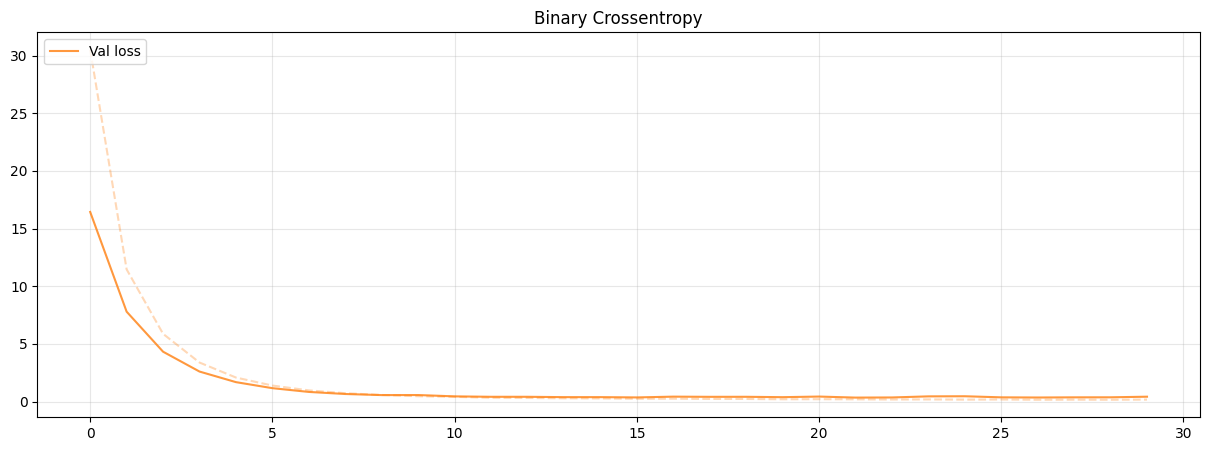

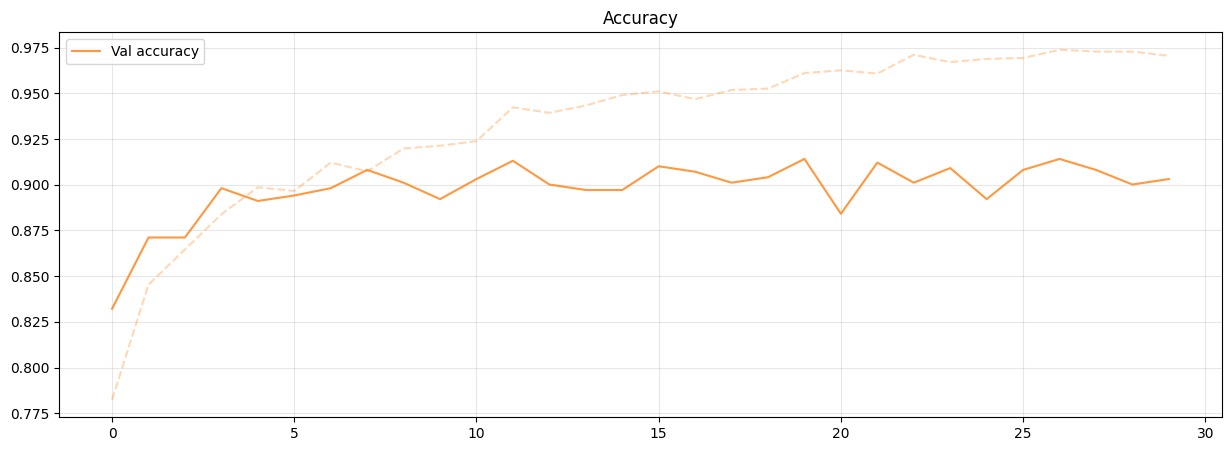

In [ ]:
# plots
plt.figure(figsize=(15,5))
#plt.ylim(-1, 2)
plt.plot(history.history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history.history['val_loss'], label='Val loss', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history.history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history.history['val_accuracy'], label='Val accuracy', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [22]:
model.save("AN2DL2023Challenge1Polimi.keras")

In [24]:
X_test = X_clean
y_test = y_clean

In [25]:
# Predict labels for the entire test set
predictions = (model.predict(X_test)>0.5).astype(int)

# Compute classification metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

157/157 ━━━━━━━━━━━━━━━━━━━━ 65s 370ms/step
Accuracy: 0.9632
Precision: 0.9624
Recall: 0.9595
F1: 0.9609
